In [46]:

import pandas as pd
import numpy as np
from datetime import date as datetime_date, timedelta
import holidays
import warnings
warnings.filterwarnings("ignore")
from pymongo import MongoClient
from calendar import monthrange
from sklearn.preprocessing import LabelEncoder
import requests
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(10,4)
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split , TimeSeriesSplit
pd.set_option('display.max_columns', 500)

In [63]:
def uom():
    try:
        sensor_ids = ['5f718b613291c7.03696209',
                '5f718c439c7a78.65267835',
                '614366bce31a86.78825897',
                '6148740eea9db0.29702291',
                '625fb44c5fb514.98107900',
                '625fb9e020ff31.33961816',
                '6260fd4351f892.69790282',
                '627cd4815f2381.31981050',
                '629094ee5fdff4.43505210',
                '62aad7f5c65185.80723547',
                '62b15dfee341d1.73837476',
                '62b595eabd9df4.71374208',
                '6349368c306542.16235883',
                '634e7c43038801.39310596',
                '6399a18b1488b8.07706749',
                '63a4195534d625.00718490',
                '63a4272631f153.67811394',
                '63aa9161b9e7e1.16208626',
                '63ca403ccd66f3.47133508',
                '62a9920f75c931.62399458'
                ]

        url = "https://multipoint.myxenius.com/Sensor_newHelper/getDataApi"
        params = {

            'sql': "SELECT id AS uuid, name AS sensorName, CASE WHEN grid_billing_type IS NOT NULL THEN grid_billing_type ELSE 'UOM' END AS uom FROM sensor WHERE id IN ({}) ORDER BY name".format(
                ','.join(f"'{sid}'" for sid in sensor_ids)),
            'type': 'query'
        }
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        sensor_list = [{'uuid': item['uuid'], 'sensorName': item['sensorName'], "UOM": item['uom']} for item in
                       data['resource']]
        df = pd.DataFrame(sensor_list)
        return df

    except Exception as e:
        print(e)

df_uom = uom()
df_uom

,uuid,sensorName,UOM
0,634e7c43038801.39310596,Aims Green HT,MWH
1,627cd4815f2381.31981050,Apex Golf Avenue HT SEN,MWH
2,62b595eabd9df4.71374208,AXIS BANK,KWH
3,629094ee5fdff4.43505210,FLORA HT SEN,MWH
4,6399a18b1488b8.07706749,GAUR ATULYAM HT,MWH
5,6349368c306542.16235883,Greenwood socity,KWH
6,625fb9e020ff31.33961816,GULSHAN Common Meter,MWH
7,625fb44c5fb514.98107900,GULSHAN HT,MWH
8,6148740eea9db0.29702291,Jamia HT METER,MWH
9,63a4195534d625.00718490,JM Commane HT,MWH


In [85]:
dfresample

,Kwh,sensor_id
Clock,,
2022-12-20 00:00:00,182.2,63ca403ccd66f3.47133508
2022-12-20 01:00:00,321.5,63ca403ccd66f3.47133508
2022-12-20 02:00:00,289.1,63ca403ccd66f3.47133508
2022-12-20 03:00:00,275.8,63ca403ccd66f3.47133508
2022-12-20 04:00:00,278.6,63ca403ccd66f3.47133508
...,...,...
2023-11-18 19:00:00,699.3,63ca403ccd66f3.47133508
2023-11-18 20:00:00,709.1,63ca403ccd66f3.47133508
2023-11-18 21:00:00,706.3,63ca403ccd66f3.47133508


In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1, gap=24)

In [87]:
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1, gap=24)
df = dfresample.sort_index()
# df.dropna(subset=['Kwh'], inplace=True)
i=0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    if test.empty is False:
        print(len(test))
    # print(i, len(train_idx), len(val_idx))
    i+=1


720
720
720
720
720


In [44]:
data= list(collection.find({"sensor_id":10},{"_id":0,"data":1}))

df1 = pd.DataFrame(data[0]['data'])
df1

,Clock,Kwh,labeled_id,sensor_id,holiday,humidity,rain,cloud_cover,wind_speed,temp_diff,lag1,lag2,lag3,lag4,lag5,lag6,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year
0,2022-12-21 00:00:00,3.0,10,62aad7f5c65185.80723547,0,88,0.0,0,8.7,-0.5,NaN,NaN,NaN,NaN,NaN,NaN,21,0,12,2,4,355,51,2022
1,2022-12-21 01:00:00,6.2,10,62aad7f5c65185.80723547,0,90,0.0,0,8.2,-0.4,NaN,NaN,NaN,3.0,NaN,NaN,21,1,12,2,4,355,51,2022
2,2022-12-21 02:00:00,6.1,10,62aad7f5c65185.80723547,0,92,0.0,3,7.5,-0.5,NaN,NaN,NaN,6.2,NaN,NaN,21,2,12,2,4,355,51,2022
3,2022-12-21 03:00:00,6.1,10,62aad7f5c65185.80723547,0,94,0.0,0,7.2,-0.5,NaN,NaN,NaN,6.1,NaN,NaN,21,3,12,2,4,355,51,2022
4,2022-12-21 04:00:00,6.1,10,62aad7f5c65185.80723547,0,96,0.0,0,8.7,-0.7,NaN,NaN,NaN,6.1,NaN,NaN,21,4,12,2,4,355,51,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7987,2023-11-18 19:00:00,283.8,10,62aad7f5c65185.80723547,0,55,0.0,0,4.2,1.8,329.8,365.2,383.0,279.8,7.9,204.0,18,19,11,5,4,322,46,2023
7988,2023-11-18 20:00:00,272.3,10,62aad7f5c65185.80723547,0,57,0.0,0,1.1,-0.5,335.4,356.3,378.4,283.8,7.0,261.2,18,20,11,5,4,322,46,2023
7989,2023-11-18 21:00:00,233.7,10,62aad7f5c65185.80723547,0,72,0.0,0,5.6,-3.9,286.9,240.0,294.7,272.3,20.8,242.1,18,21,11,5,4,322,46,2023
7990,2023-11-18 22:00:00,16.7,10,62aad7f5c65185.80723547,0,76,0.0,0,6.4,-0.6,83.6,9.1,114.1,233.7,77.1,37.3,18,22,11,5,4,322,46,2023


In [88]:
mongo_url = "mongodb://localhost:27017"
client = MongoClient(mongo_url)
db = client["pvvnl"]
collection = db["prediction_h"]

In [95]:
data= list(collection.find({"sensor_id":1},{"_id":0, "data":1}))
len(data[0]['data'])

720

In [14]:
def initialize_mongodb():
    try:


        # print(collection.count_documents({}))
        document_count = collection.count_documents({})
        if document_count != 0:
            db.drop_collection("test2")
        # print(collection.count_documents({}))

        return client, collection, document_count
    except Exception as e:
            print(e)  
a,b , c= initialize_mongodb()
print(a)
print(b)
print(c)

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)
Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'pvvnl'), 'test2')
0


In [17]:
list(collection.find({"sensor_id":0}, {'_id': 0, 'data': 1}))

[]

In [128]:
def mongo(collection_name):
    mongo_url = "mongodb://localhost:27017"
    client = MongoClient(mongo_url)
    db = client["pvvnl"]
    collection1  = db["prediction_h"]
    collection = db['test_data']
    collection2 = db["train_data"]

    if type(collection_name)== list:
        return collection, collection1, collection2
    elif collection_name == "sensor":
        print("1")
        return collection
    elif collection_name == "train":
        print("2")
        return collection1
    elif collection_name == "test":
        print("3")
        return collection2
    # else:
    #     print("4")
    # return db

In [129]:
lst = ["sensor", 'train', 'test']
# for i in lst:
#     c=hard(i)
    # print(c)
x=mongo('sensor')

1


In [135]:
# x.full_name
x.name

'test_data'

In [40]:
df=pd.read_parquet("d:/data.parquet")

In [43]:
df.set_index("Clock",inplace=True,drop=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2022-11-18 00:00:00 to 2023-11-18 23:00:00
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kwh          8784 non-null   float64
 1   seasonal     8784 non-null   float64
 2   trend        8784 non-null   float64
 3   resid        8784 non-null   float64
 4   labeled_id   8784 non-null   int64  
 5   sensor_id    8784 non-null   object 
 6   holiday      8784 non-null   int64  
 7   temp         8784 non-null   float64
 8   humidity     8784 non-null   int64  
 9   rain         8784 non-null   float64
 10  cloud_cover  8784 non-null   int64  
 11  wind_speed   8784 non-null   float64
 12  lag1         8064 non-null   float64
 13  lag2         7344 non-null   float64
 14  lag3         6624 non-null   float64
 15  day          8784 non-null   int32  
 16  hour         8784 non-null   int32  
 17  month        8784 non-null   int32  
 18  dayofweek   

In [45]:
df["temp_diff"]=df['temp']-df['temp'].shift(1)

In [46]:
df.columns

Index(['Kwh', 'seasonal', 'trend', 'resid', 'labeled_id', 'sensor_id',
       'holiday', 'temp', 'humidity', 'rain', 'cloud_cover', 'wind_speed',
       'lag1', 'lag2', 'lag3', 'day', 'hour', 'month', 'dayofweek', 'quarter',
       'dayofyear', 'weekofyear', 'year', 'temp_diff'],
      dtype='object')

In [48]:
df.head()

,Kwh,seasonal,trend,resid,labeled_id,sensor_id,holiday,temp,humidity,rain,...,lag3,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year,temp_diff
Clock,,,,,,,,,,,,,,,,,,,,,
2022-11-18 00:00:00,261.3,0.0,261.3,0.0,1,5f718c439c7a78.65267835,0,14.8,74,0.0,...,NaN,18,0,11,4,4,322,46,2022,NaN
2022-11-18 01:00:00,509.1,0.0,509.1,0.0,1,5f718c439c7a78.65267835,0,14.5,75,0.0,...,NaN,18,1,11,4,4,322,46,2022,-0.3
2022-11-18 02:00:00,481.5,0.0,481.5,0.0,1,5f718c439c7a78.65267835,0,14.1,76,0.0,...,NaN,18,2,11,4,4,322,46,2022,-0.4
2022-11-18 03:00:00,472.2,0.0,472.2,0.0,1,5f718c439c7a78.65267835,0,13.6,77,0.0,...,NaN,18,3,11,4,4,322,46,2022,-0.5
2022-11-18 04:00:00,480.8,0.0,480.8,0.0,1,5f718c439c7a78.65267835,0,13.0,78,0.0,...,NaN,18,4,11,4,4,322,46,2022,-0.6


In [49]:
# df['temp_diff'].dropna(inplace=True)
# df.isna().sum()
# df.iloc[0].drop(inplace=True)
df.drop(index="2022-11-18 00:00:00", inplace=True)
df.head()
# df.loc[0].drop()
# df.dropna(inplace=True)


,Kwh,seasonal,trend,resid,labeled_id,sensor_id,holiday,temp,humidity,rain,...,lag3,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year,temp_diff
Clock,,,,,,,,,,,,,,,,,,,,,
2022-11-18 01:00:00,509.1,0.0,509.1,0.0,1,5f718c439c7a78.65267835,0,14.5,75,0.0,...,NaN,18,1,11,4,4,322,46,2022,-0.3
2022-11-18 02:00:00,481.5,0.0,481.5,0.0,1,5f718c439c7a78.65267835,0,14.1,76,0.0,...,NaN,18,2,11,4,4,322,46,2022,-0.4
2022-11-18 03:00:00,472.2,0.0,472.2,0.0,1,5f718c439c7a78.65267835,0,13.6,77,0.0,...,NaN,18,3,11,4,4,322,46,2022,-0.5
2022-11-18 04:00:00,480.8,0.0,480.8,0.0,1,5f718c439c7a78.65267835,0,13.0,78,0.0,...,NaN,18,4,11,4,4,322,46,2022,-0.6
2022-11-18 05:00:00,515.1,0.0,515.1,0.0,1,5f718c439c7a78.65267835,0,12.6,82,0.0,...,NaN,18,5,11,4,4,322,46,2022,-0.4


<Axes: xlabel='Clock'>

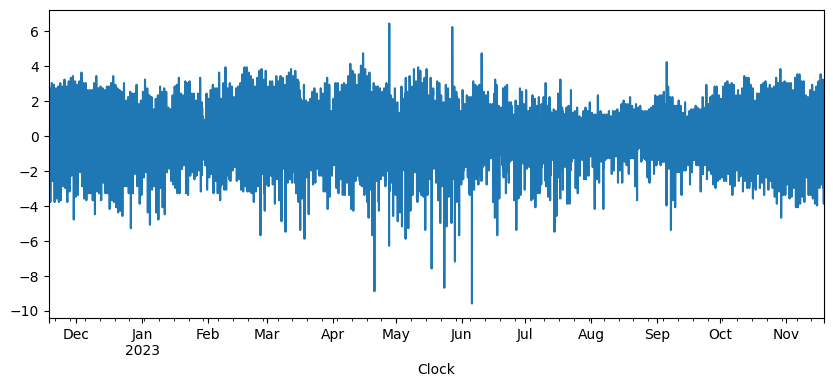

In [50]:
# df['temp'].plot()
df['temp_diff'].plot()

In [51]:
df['temp_diff'].describe()

count    8783.000000
mean        0.000205
std         1.364058
min        -9.600000
25%        -0.700000
50%        -0.200000
75%         0.800000
max         6.400000
Name: temp_diff, dtype: float64

In [52]:
df[df['temp_diff']<-7]

,Kwh,seasonal,trend,resid,labeled_id,sensor_id,holiday,temp,humidity,rain,...,lag3,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year,temp_diff
Clock,,,,,,,,,,,,,,,,,,,,,
2023-04-20 17:00:00,1183.7,0.0,1183.7,0.0,1,5f718c439c7a78.65267835,0,25.0,65,0.0,...,987.3,20,17,4,3,2,110,16,2023,-8.9
2023-05-17 17:00:00,1597.9,0.0,1597.9,0.0,1,5f718c439c7a78.65267835,0,32.6,34,0.0,...,699.5,17,17,5,2,2,137,20,2023,-7.6
2023-05-23 17:00:00,2208.1,0.0,2208.1,0.0,1,5f718c439c7a78.65267835,0,31.5,39,0.0,...,753.4,23,17,5,1,2,143,21,2023,-8.7
2023-05-28 17:00:00,1405.1,0.0,1405.1,0.0,1,5f718c439c7a78.65267835,1,26.5,68,0.0,...,771.8,28,17,5,6,2,148,21,2023,-7.2
2023-06-05 18:00:00,1249.7,0.0,1249.7,0.0,1,5f718c439c7a78.65267835,0,27.1,60,0.1,...,771.7,5,18,6,0,2,156,23,2023,-9.6


In [58]:
df.loc["2023-06-05"]#[['temp_diff','temp']]
# selected_row = df[df['2023-04-20'] == "2023-04-20"]


,Kwh,seasonal,trend,resid,labeled_id,sensor_id,holiday,temp,humidity,rain,...,lag3,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year,temp_diff
Clock,,,,,,,,,,,,,,,,,,,,,
2023-06-05 00:00:00,1839.6,0.0,1839.6,0.0,1,5f718c439c7a78.65267835,0,26.3,69,0.0,...,680.4,5,0,6,0,2,156,23,2023,-0.4
2023-06-05 01:00:00,1638.2,0.0,1638.2,0.0,1,5f718c439c7a78.65267835,0,26.1,71,0.0,...,610.7,5,1,6,0,2,156,23,2023,-0.2
2023-06-05 02:00:00,1516.0,0.0,1516.0,0.0,1,5f718c439c7a78.65267835,0,25.8,73,0.0,...,565.9,5,2,6,0,2,156,23,2023,-0.3
2023-06-05 03:00:00,1410.6,0.0,1410.6,0.0,1,5f718c439c7a78.65267835,0,25.5,75,0.0,...,546.3,5,3,6,0,2,156,23,2023,-0.3
2023-06-05 04:00:00,1293.0,0.0,1293.0,0.0,1,5f718c439c7a78.65267835,0,25.4,76,0.0,...,544.4,5,4,6,0,2,156,23,2023,-0.1
2023-06-05 05:00:00,1251.7,0.0,1251.7,0.0,1,5f718c439c7a78.65267835,0,26.2,73,0.0,...,559.1,5,5,6,0,2,156,23,2023,0.8
2023-06-05 06:00:00,1142.7,0.0,1142.7,0.0,1,5f718c439c7a78.65267835,0,27.3,70,0.0,...,620.1,5,6,6,0,2,156,23,2023,1.1
2023-06-05 07:00:00,1184.3,0.0,1184.3,0.0,1,5f718c439c7a78.65267835,0,28.9,62,0.0,...,852.3,5,7,6,0,2,156,23,2023,1.6
2023-06-05 08:00:00,1003.4,0.0,1003.4,0.0,1,5f718c439c7a78.65267835,0,31.0,53,0.0,...,961.2,5,8,6,0,2,156,23,2023,2.1


In [19]:
scaling=MinMaxScaler()

In [ ]:
df.columns

In [ ]:
Visualize(df)

In [23]:
df2=scaling.fit_transform(df[['Kwh','holiday', 'temp', 'humidity', 'rain', 'cloud_cover', 'wind_speed','temp_diff']])

In [25]:
df1=pd.DataFrame(df2)
df1.columns=['Kwh','holiday', 'temp', 'humidity', 'rain', 'cloud_cover', 'wind_speed','temp_diff']

In [26]:
for i in range((len(df1.columns))):
    if (df1[df1.columns[i]].nunique()>1) & (df1[df1.columns[i]].isna().sum()==0):
        result=adfuller(df1[df1.columns[i]])
        if result[1]< 0.05:
            print(df1.columns[i],"stationary",result[1])
            pass
        else:
            print(df1.columns[i],"not stationary",result[1])
    else:
        print(df1.columns[i])

Kwh stationary 0.026128243362752802
holiday stationary 1.8090374440110885e-19
temp not stationary 0.19394071230541138
humidity stationary 3.3899416056266765e-05
rain stationary 1.6246119677863246e-17
cloud_cover stationary 8.514651957668998e-12
wind_speed stationary 1.5130986866404242e-16
temp_diff stationary 4.934272826000741e-28


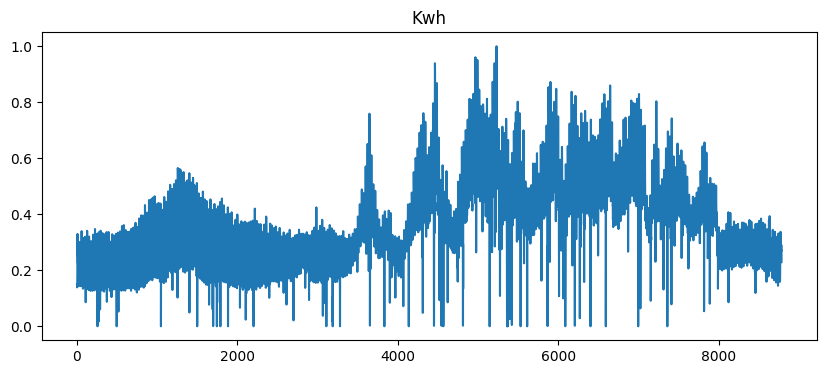

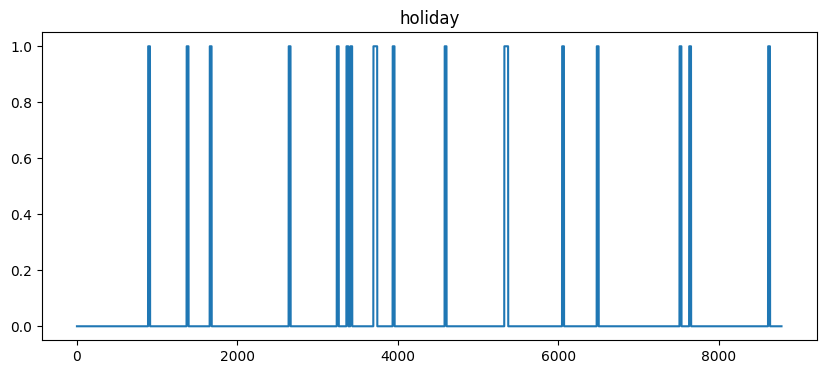

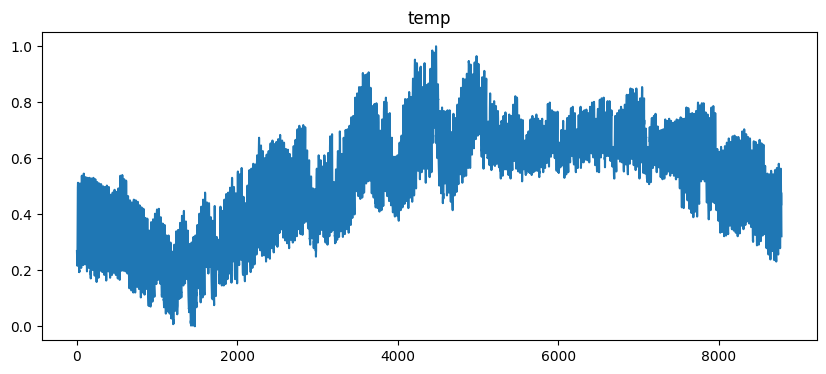

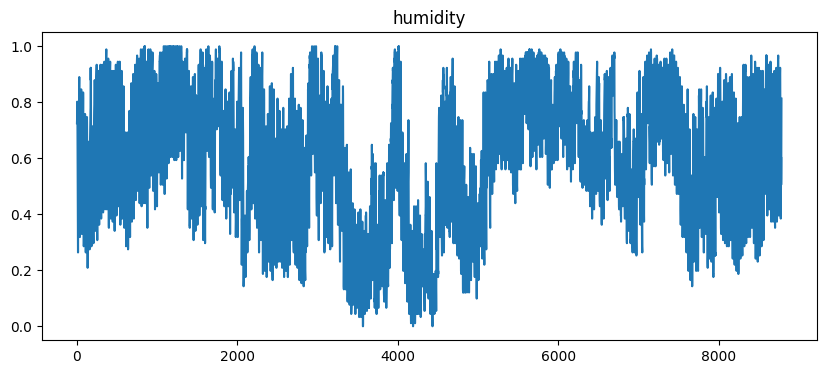

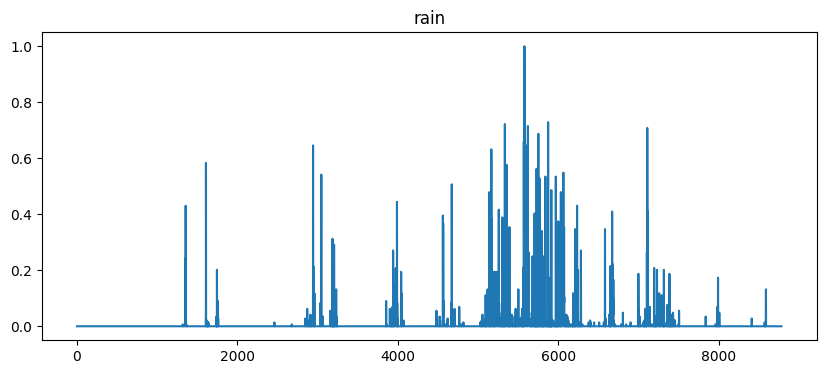

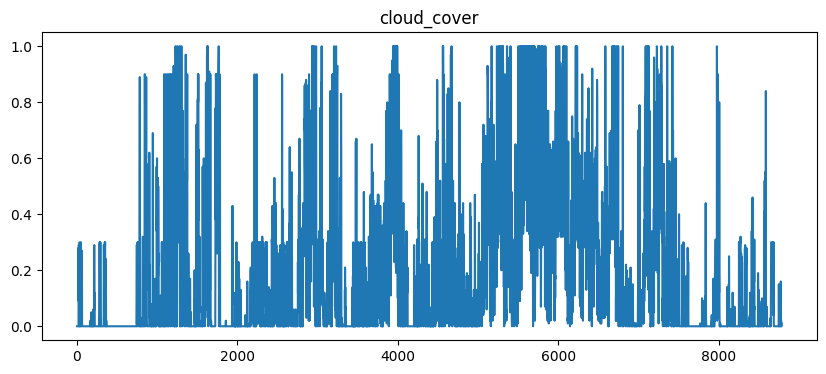

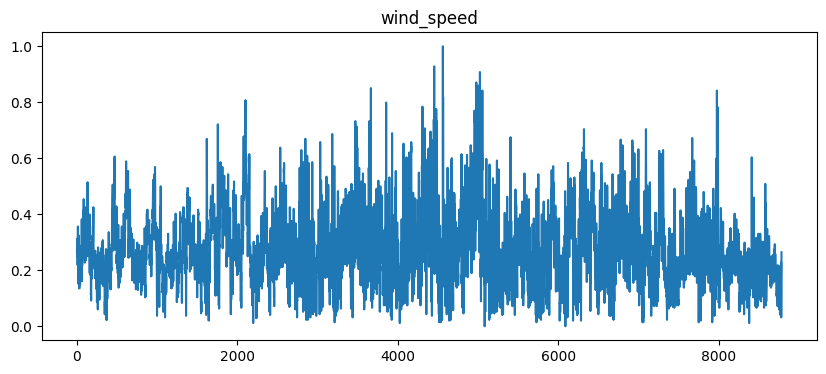

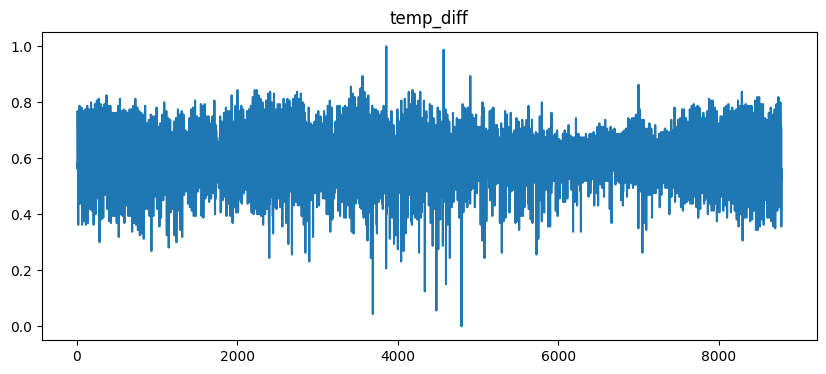

In [27]:
for i in range(len(df1.columns)):
    plt.plot(df1[df1.columns[i]])
    plt.title(df1.columns[i])
    plt.show()

In [ ]:
for i in range((len(df1.columns))):
    result=adfuller(df1[df1.columns[i]])
    if result[1]< 0.05:
        print(df1.columns[i],"stationary",result[1])
    else:
        print(df1.columns[i],"not stationary",result[1])

In [ ]:
df1.describe()

In [ ]:
max_lags=8
y='Kwh'
     

In [ ]:

for i in range(len(df1.columns)-1):
  results=grangercausalitytests(df[[y,df1.columns[i+1]]], max_lags, verbose=False)
  p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(df1.columns[i+1],p_values))


In [ ]:

color_list = ["blue","orange","red","purple","brown","pink","gray","olive","cyan",]

def Visualize(data):
    features= list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(20,feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(df1)

In [ ]:
for i in range((len(df1.columns))):
    result=adfuller(df1[df1.columns[i]])
    if result[1]< 0.05:
        print(df1.columns[i],"stationary",result[1])
    else:
        print(df1.columns[i],"not stationary",result[1])

In [9]:

def data_from_weather_api():
    ''' weather data'''
    l1=[]
    value=[]
    start_date = "2022-11-18"
    end_date = "2023-11-18"
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude=28.58&longitude=77.33&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relative_humidity_2m,rain,cloud_cover,wind_speed_10m&timezone=auto"
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    l1.append(data)
    
    data1=l1[0]
    data_dict=data1['hourly']
    
    for i in range(len(data_dict['time'])):
        value.append({
                    "Clock":data_dict['time'][i],
                    "temp":data_dict['temperature_2m'][i],
                    "humidity":data_dict['relative_humidity_2m'][i],
                    "rain":data_dict['rain'][i],
                    "cloud_cover":data_dict['cloud_cover'][i],
                    "wind_speed":data_dict['wind_speed_10m'][i],
                    
                    })
    df=pd.DataFrame(value)
    df['Clock']=pd.to_datetime(df['Clock'])
    df.set_index("Clock",inplace=True, drop=True)
    df["temp_diff"]=df['temp']-df['temp'].shift(1)
    # df.drop(['temp'],axis=1,inplace=True)
    # df.dropna(inplace=True)
    return df
data_from_weather_api()

,temp,humidity,rain,cloud_cover,wind_speed,temp_diff
Clock,,,,,,
2022-11-18 00:00:00,14.8,74,0.0,0,9.3,NaN
2022-11-18 01:00:00,14.5,75,0.0,0,9.5,-0.3
2022-11-18 02:00:00,14.1,76,0.0,0,9.0,-0.4
2022-11-18 03:00:00,13.6,77,0.0,0,9.4,-0.5
2022-11-18 04:00:00,13.0,78,0.0,0,9.0,-0.6
...,...,...,...,...,...,...
2023-11-18 19:00:00,22.8,55,0.0,0,4.2,1.8
2023-11-18 20:00:00,22.3,57,0.0,0,1.1,-0.5
2023-11-18 21:00:00,18.4,72,0.0,0,5.6,-3.9
